In [1]:
# !pip install torch==2.6.0 torchvision==0.21.0 torchaudio==2.6.0 --index-url https://download.pytorch.org/whl/cu124
# !pip install flash-attn===1.0.4 --no-build-isolation
# !pip install huggingface_hub==0.36.0
# !pip install transformers==4.51.3

In [2]:
import io
import os
import re
import json
import torch
import base64

import requests
import numpy as np
from PIL import Image
from io import BytesIO

from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelForCausalLM, AutoProcessor
from transformers.dynamic_module_utils import get_imports
from tqdm import tqdm
from typing import List, Dict, Any, Tuple, Generator
from roboflow import Roboflow

/root/miniconda3/envs/.venv-florence-2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
CACHE_DIR = "./cache"
CHECKPOINT = "microsoft/Florence-2-base-ft"
REVISION = 'refs/pr/6'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")    
from unittest.mock import patch
from transformers.dynamic_module_utils import get_imports

model = AutoModelForCausalLM.from_pretrained(CHECKPOINT, trust_remote_code=True, revision=REVISION, cache_dir=CACHE_DIR, attn_implementation="eager").to(DEVICE)
processor = AutoProcessor.from_pretrained(CHECKPOINT, trust_remote_code=True, revision=REVISION, cache_dir=CACHE_DIR, attn_implementation="eager")

Importing from timm.models.layers is deprecated, please import via timm.layers
Florence2LanguageForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


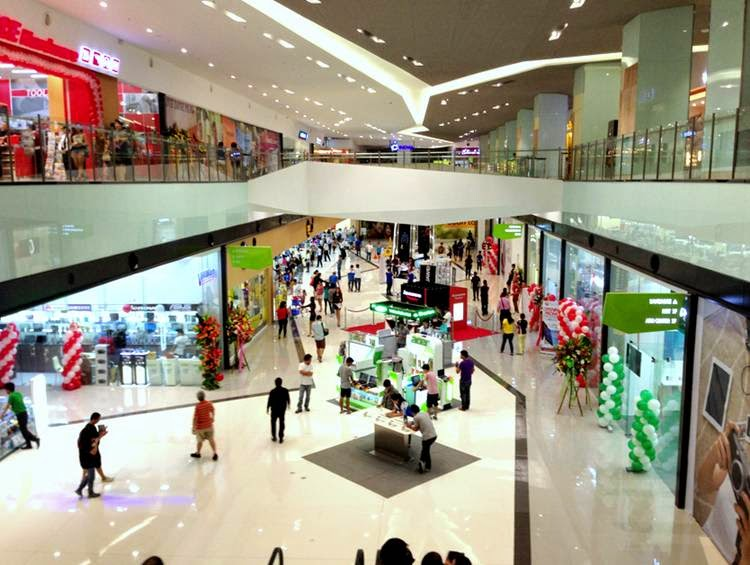

In [4]:
URL = "https://1.bp.blogspot.com/-1OiYytlrNoc/VQ6m0zn00CI/AAAAAAAAi_M/2Nc_D36ztVs/s1600/image028.jpg"
response = requests.get(URL)
image = Image.open(BytesIO(response.content))
image.show()

In [5]:
task = "<DETAILED_CAPTION>"
text = "<DETAILED_CAPTION>"

inputs = processor(text=text, images=image, return_tensors="pt").to(DEVICE)
generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    num_beams=3
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
response = processor.post_process_generation(generated_text, task=task, image_size=(image.width, image.height))
response

{'<DETAILED_CAPTION>': 'In this image we can see a group of people standing on the floor. We can also see some tables containing some objects placed on it. On the right side of the image we see a photo frame on a wall and a camera placed on a stand. In the center of the picture we see the flower bouquets. At the top we see lights and the ceiling.'}